# Ch09

In [2]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2022-05-21 16:42:47--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2022-05-21 16:42:47--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48687 (48K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.55K  --.-KB/s    in 0.01s   

2022-05-21 16:42:47 (4.69 MB/s) - ‘thinkdsp.py’ saved [48687/48687]



In [3]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

# Exercise 01

In [4]:
if not os.path.exists('FB_2.csv'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv

--2022-05-21 16:42:48--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/FB_2.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/FB_2.csv [following]
--2022-05-21 16:42:48--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/FB_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143920 (141K) [text/plain]
Saving to: ‘FB_2.csv’

FB_2.csv            100%[===================>] 140.55K  --.-KB/s    in 0.02s   

2022-05-21 16:42:49 (5.96 MB/s) - ‘FB_2.csv’ saved [143920/143920]



In [5]:
import pandas as pd

df = pd.read_csv('FB_2.csv', header=0, parse_dates=[0])
len(df)

1977

In [6]:
from thinkdsp import Wave

ys = df['Close']

# for these examples, we need the wave to have 
# an even number of samples
if len(ys) % 2:
    ys = ys[:-1]

close = Wave(ys, framerate=1)
len(close)

1976

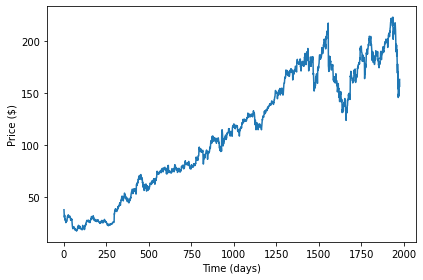

In [7]:
close.plot()
decorate(xlabel='Time (days)', ylabel='Price ($)')

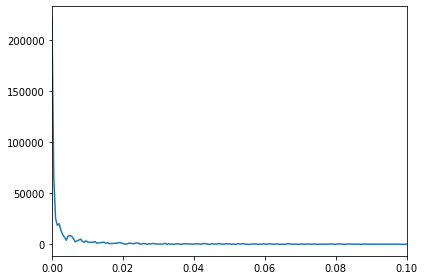

In [25]:
close.make_spectrum().plot()
decorate(xlim=(0.0,0.1))

In [8]:
from thinkdsp import zero_pad

# compute the diff filter
diff_window = np.array([1.0, -1.0])
padded = zero_pad(diff_window, len(close))
diff_wave = Wave(padded, framerate=close.framerate)
diff_filter = diff_wave.make_spectrum()
# compute the cumsum filter by inverting the diff filter
cumsum_filter = diff_filter.copy()
cumsum_filter.hs[1:] = 1 / cumsum_filter.hs[1:]
cumsum_filter.hs[0] = np.inf
# compute the integration filter
integ_filter = cumsum_filter.copy()
integ_filter.hs[1:] = integ_filter.framerate / (np.pi*2 * 1j * integ_filter.fs[1:])
integ_filter.hs[0] = np.inf

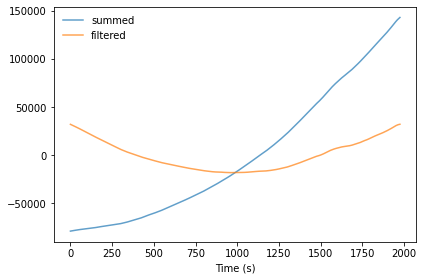

In [9]:
out_wave = close.cumsum()
out_wave.unbias()
out_wave.plot(label='summed', alpha=0.7)

cumsum_filter.hs[0] = 0
out_wave2 = (close.make_spectrum() * cumsum_filter).make_wave()
out_wave2.plot(label='filtered', alpha=0.7)

decorate(xlabel='Time (s)')

這邊可以看到，對非週期信號累加(cumsum)，可以正常相加；而應用卷積定理，將頻率域與積分濾波器相乘，會得到錯誤的對稱結果。

在計算FFT時，會先將訊號離散化與週期化。也就是變成週期性的訊號，才能用FFT運算。此時頻率域的相乘會受前後訊號的影響，但前後訊號又不相同，就會讓結果錯誤。

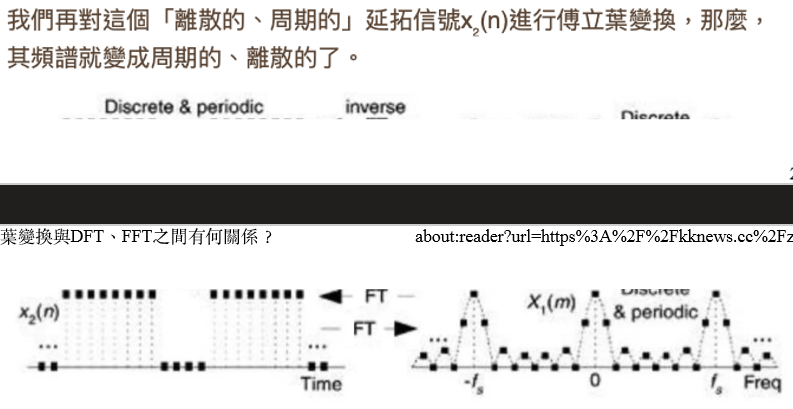

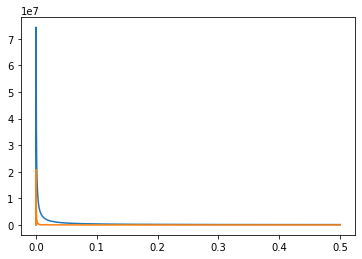

In [22]:
out_wave.make_spectrum().plot()
out_wave2.make_spectrum().plot()

# Exercise 02

各項波形的微分與積分結果 :

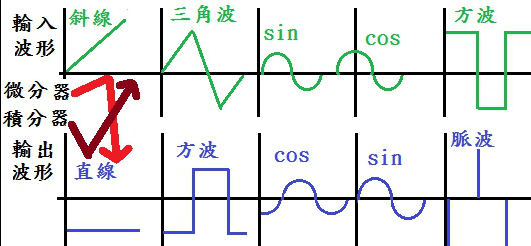


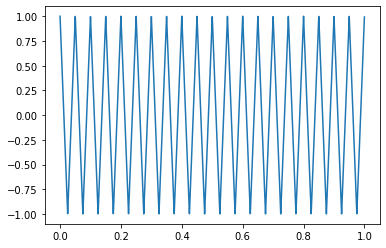

In [12]:
from thinkdsp import TriangleSignal
fr = 11025
tri_wave = TriangleSignal(freq=20).make_wave(framerate=fr)
tri_wave.plot()

依題目要求，製作一個三角波。

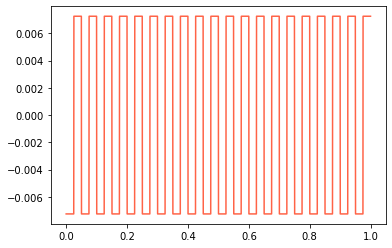

In [13]:
diff_tri_wave = Wave(np.diff(tri_wave.ys), framerate=fr)
diff_tri_wave.plot(color='tomato')

差分計算的波行圖，相當漂亮。

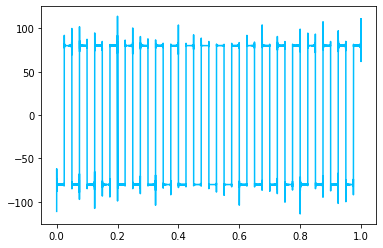

In [14]:
dir_tri_spec = tri_wave.make_spectrum().differentiate()
dir_tri_wave = dir_tri_spec.make_wave()
dir_tri_wave.ys = dir_tri_wave.ys[1:]
dir_tri_wave.ts = dir_tri_wave.ts[1:]
dir_tri_wave.plot(color='deepskyblue')

微分計算的波形圖，三角波的微分為方波，帶有些許震盪雜訊。

這個現象稱為振鈴（Ringing），是變化訊號中非預期的震盪。如方波先出現過高，後出現過低的現象。可以參考 : https://zh.wikipedia.org/wiki/%E6%8C%AF%E9%88%B4

產生的原因為三角波頂點的微分值不定(微分值跳動)，造成的結果。

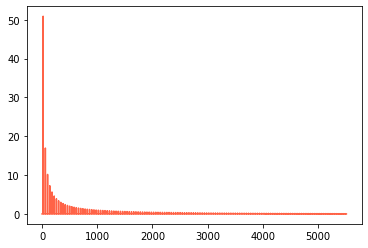

In [15]:
diff_tri_spec = diff_tri_wave.make_spectrum()
diff_tri_spec.plot(color='tomato')

差分計算的頻譜圖。

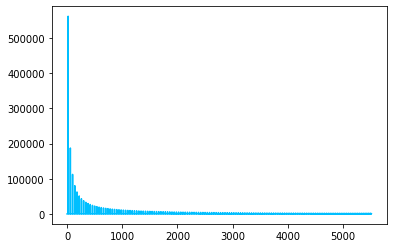

In [16]:
dir_tri_spec = dir_tri_wave.make_spectrum()
dir_tri_spec.plot(color='deepskyblue')

微分計算的頻譜圖。

# Exercise 03

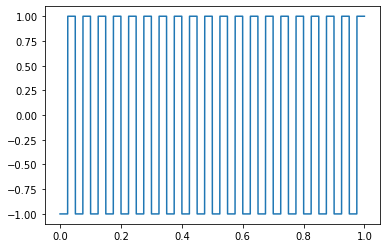

In [17]:
from thinkdsp import SquareSignal
sqr_wave = SquareSignal(freq=20).make_wave(framerate=fr)
sqr_wave.plot()

依題目要求，製作一個方波。

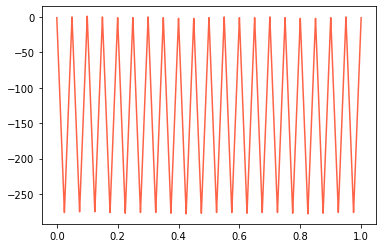

In [18]:
cum_sqr_wave = Wave(np.cumsum(sqr_wave.ys), framerate=fr)
cum_sqr_wave.plot(color='tomato')

累積和的波形圖，相當漂亮。

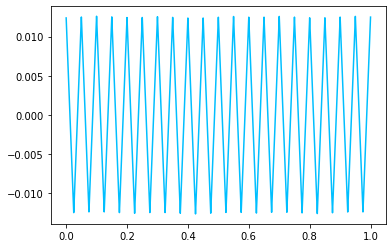

In [19]:
int_sqr_spec = sqr_wave.make_spectrum().integrate()
int_sqr_spec.hs[0] = 0 #第一項=inf，需要移除
int_sqr_wave = int_sqr_spec.make_wave()
int_sqr_wave.ys = int_sqr_wave.ys[1:]
int_sqr_wave.ts = int_sqr_wave.ts[1:]
int_sqr_wave.plot(color='deepskyblue')

積分的波形圖，方波的積分結果為三角波，相當漂亮，與累積和基本相同。

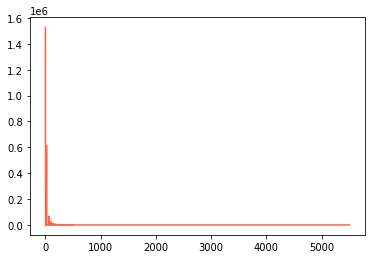

In [20]:
cum_sqr_spec = cum_sqr_wave.make_spectrum()
cum_sqr_spec.plot(color='tomato')

累積和的頻譜圖。

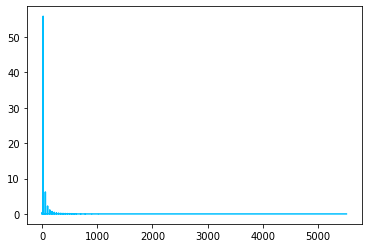

In [21]:
int_sqr_spec.plot(color='deepskyblue')

積分的頻譜圖。

---

這次程式碼好多，也有很多新的觀念，花了不少時間測試和理解 !
